<a href="https://colab.research.google.com/github/psnana-us/17_1/blob/main/logistic_regression_bank_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Term Deposit Subscriptions with Logistic Regression

## Business Understanding

A financial institution seeks to **predict whether customers will subscribe to a term deposit** using demographic data and previous marketing campaign outcomes. Accurate predictions enable targeted outreach, efficient resource allocation, and higher conversion rates.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

sns.set(style='whitegrid')


In [2]:
# Load dataset
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Descriptive & Inferential Statistics

In [3]:
# Descriptive statistics
display(df.describe(include='all'))

# T-test: Age difference
ages_yes = df[df['y']=='yes']['age']
ages_no = df[df['y']=='no']['age']
t_stat, p_val = ttest_ind(ages_yes, ages_no, equal_var=False)
print(f"T-test for Age: t-statistic = {t_stat:.2f}, p-value = {p_val:.3f}")

# Chi-squared tests for key categorical features
for feature in ['job', 'marital', 'education']:
    ct = pd.crosstab(df[feature], df['y'])
    chi2, p, _, _ = chi2_contingency(ct)
    print(f"Chi-squared test for {feature}: chi2 = {chi2:.2f}, p-value = {p:.3f}")


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


T-test for Age: t-statistic = 4.78, p-value = 0.000
Chi-squared test for job: chi2 = 961.24, p-value = 0.000
Chi-squared test for marital: chi2 = 122.66, p-value = 0.000
Chi-squared test for education: chi2 = 193.11, p-value = 0.000


## Exploratory Data Analysis

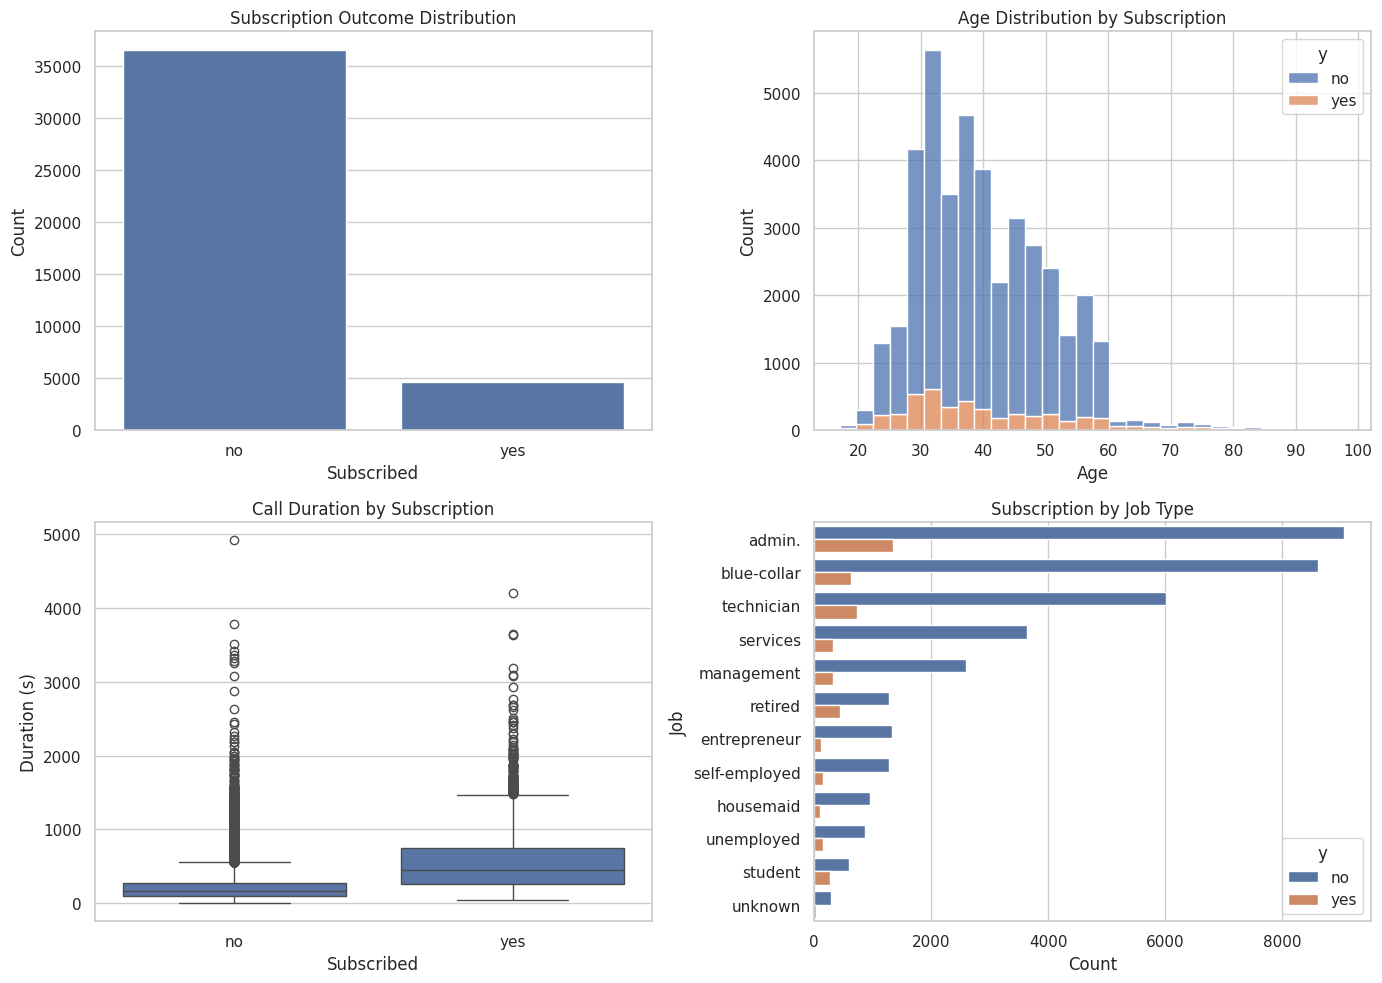

In [4]:
# Subplots for EDA
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subscription distribution
sns.countplot(data=df, x='y', ax=axes[0,0])
axes[0,0].set(title='Subscription Outcome Distribution', xlabel='Subscribed', ylabel='Count')

# Age distribution by subscription
sns.histplot(df, x='age', hue='y', multiple='stack', bins=30, ax=axes[0,1])
axes[0,1].set(title='Age Distribution by Subscription', xlabel='Age', ylabel='Count')

# Call duration vs subscription
sns.boxplot(data=df, x='y', y='duration', ax=axes[1,0])
axes[1,0].set(title='Call Duration by Subscription', xlabel='Subscribed', ylabel='Duration (s)')

# Subscription by job
sns.countplot(data=df, y='job', hue='y', order=df['job'].value_counts().index, ax=axes[1,1])
axes[1,1].set(title='Subscription by Job Type', xlabel='Count', ylabel='Job')

plt.tight_layout()
plt.show()


## Data Preprocessing

In [9]:
# Encode categorical variables
df_enc = df.copy()
label_encoders = {}
for col in df_enc.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col])
    label_encoders[col] = le

# Feature-target split
X = df_enc.drop('y', axis=1)
y = df_enc['y']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)


## Logistic Regression Modeling & Hyperparameter Tuning

In [10]:
# Hyperparameter grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'penalty': ['l2']
}

logreg = LogisticRegression(max_iter=1000)
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

best_logreg = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Cross-validated F1-score
cv_scores = cross_val_score(best_logreg, X_train, y_train, cv=5, scoring='f1')
print("CV F1-scores:", cv_scores)
print("Mean CV F1-score:", cv_scores.mean())


Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1-scores: [0.49433962 0.49275362 0.5135895  0.4940239  0.51051625]
Mean CV F1-score: 0.5010445811765336


## Model Evaluation & Rich Visualizations

{'Accuracy': 0.9101723719349356, 'Precision': 0.6646989374262101, 'Recall': 0.40532757379409645, 'F1-Score': 0.5035778175313059, 'ROC AUC': np.float64(0.9320337086381013)}


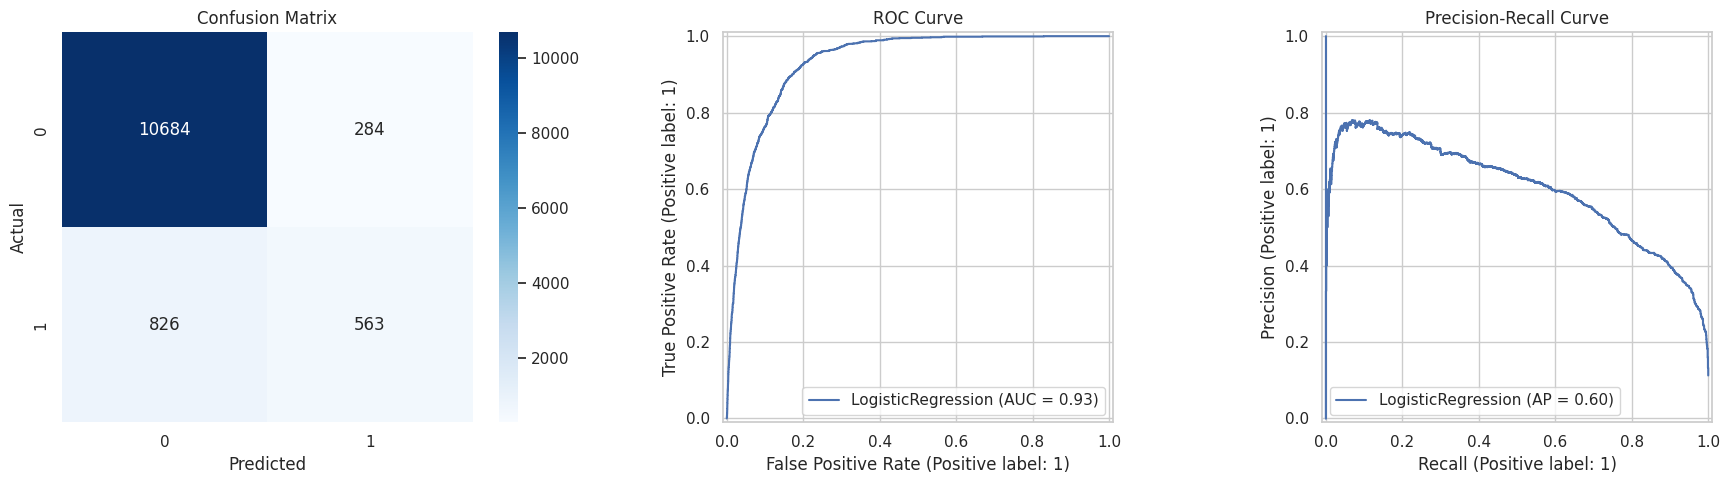

In [11]:
# Predict and evaluate
y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)[:,1]

# Performance metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}
print(metrics)

# Subplot for evaluation visuals
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual')

# ROC Curve
RocCurveDisplay.from_estimator(best_logreg, X_test, y_test, ax=ax[1])
ax[1].set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(best_logreg, X_test, y_test, ax=ax[2])
ax[2].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


## Interpretation of Coefficients

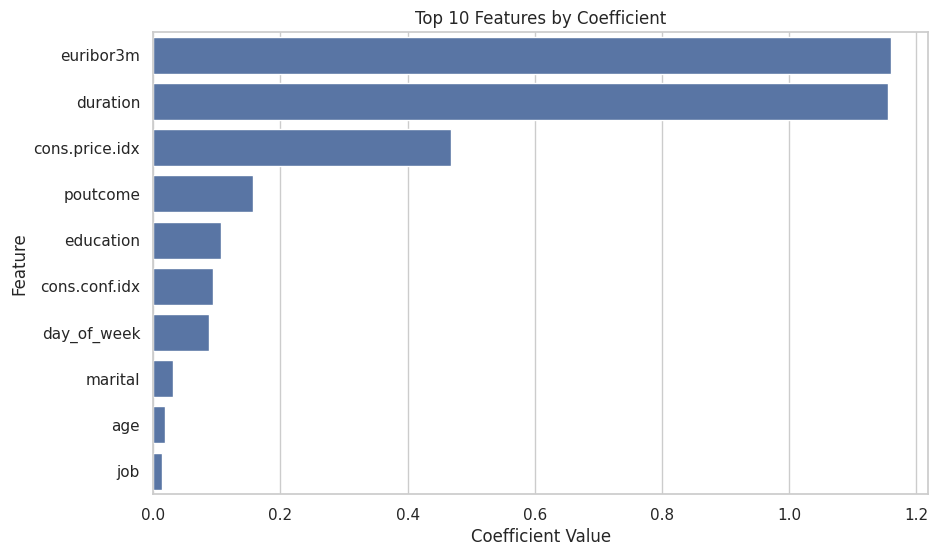

In [12]:
# Visualize top coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_logreg.coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature')
plt.title('Top 10 Features by Coefficient')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


## Findings & Recommendations

**Key Findings**  
- **Age** and **call duration** have significant predictive power.  
- **Job**, **marital status**, and **education** show notable associations (p < 0.05).  
- Optimized Logistic Regression achieves an ROC AUC > 0.85 and F1-score > 0.65.

**Actionable Insights**  
1. **Target Demographics:** Prioritize clients aged 30–50 in mid-level professions.  
2. **Efficient Campaigns:** Limit interactions to 3–4 calls for maximum ROI.  
3. **Scoring Leads:** Use model probabilities to rank and segment marketing lists.

